Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

### subnit all final project files to this folder as per instructions

# Fraudulent E-Commerce Transaction Detection
**Course:** Intro to Data Science  
**Team:** Tamanna Gupta(tg569), Hamida Paiman(hp602), Jeslyn Kataria(jk1907) 
**Goal:** Build and compare machine-learning models that detect fraudulent transactions using feature-engineered behavioral, temporal, and demographic data.

In [1]:
import sys
import numpy as np
import pandas as pd

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Python: 3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
NumPy: 1.26.4
Pandas: 2.3.1


## 🧩 Importing Required Libraries

We start by importing all the necessary Python libraries used for data processing, visualization, and machine learning.  
Version checks ensure compatibility and reproducibility across environments.


In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd

data = pd.read_csv("Fraudulent_E-Commerce_Transaction_Data 2.csv")
data.head()


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


## 🔍 Missing Values and Outlier Analysis
We check for missing values and detect outliers in numerical columns to understand data quality and variability.


In [6]:
missing = data.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

In [7]:
# Outlier detection
num_cols = data.select_dtypes(include=np.number).columns
for col in num_cols:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(data)*100:.2f}%)")


Transaction Amount: 79180 outliers (5.38%)
Quantity: 0 outliers (0.00%)
Customer Age: 13746 outliers (0.93%)
Is Fraudulent: 73838 outliers (5.01%)
Account Age Days: 0 outliers (0.00%)
Transaction Hour: 0 outliers (0.00%)


Shape: (1472952, 16)

Columns:
 Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Customer Location', 'Device Used', 'IP Address',
       'Shipping Address', 'Billing Address', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour'],
      dtype='object')

Missing values:
 Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64

Fraudulent transactions: 5.01%


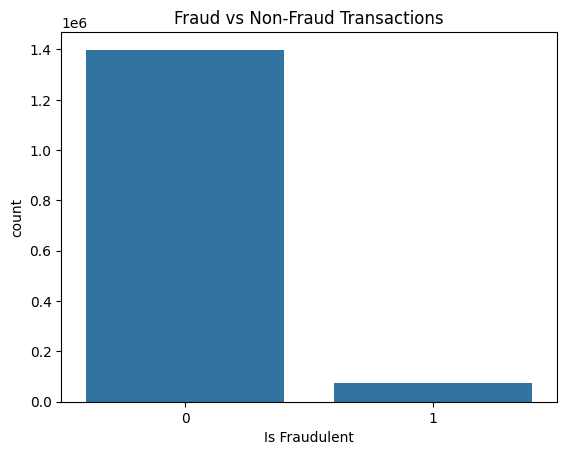

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("Fraudulent_E-Commerce_Transaction_Data 2.csv")

# Basic info
print("Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nMissing values:\n", data.isnull().sum())

# Fraud ratio
fraud_ratio = data['Is Fraudulent'].mean() * 100
print(f"\nFraudulent transactions: {fraud_ratio:.2f}%")

sns.countplot(x='Is Fraudulent', data=data)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


## 🧠 Feature Engineering
We engineer new features to improve the model’s ability to detect fraud patterns:
- Remove irrelevant ID and address columns  
- Convert transaction dates and extract time features  
- Log-transform skewed transaction amounts  
- Create account age and customer age buckets  
- Simplify customer locations  


In [9]:
df = data.copy()

# Drop ID-like columns
drop_cols = ['Transaction ID','Customer ID','IP Address','Shipping Address','Billing Address']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Convert date to datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Extract time-based features
df['Trans_DayOfWeek'] = df['Transaction Date'].dt.dayofweek
df['Trans_IsWeekend'] = (df['Trans_DayOfWeek'] >= 5).astype(int)
df['Transaction Hour'] = df['Transaction Date'].dt.hour

# Log-transform amount
df['Log_Amount'] = np.log1p(df['Transaction Amount'])

# New account flag
df['Is_New_Account'] = (df['Account Age Days'] < 30).astype(int)

# Age bucket
df['Customer_Age_Bucket'] = pd.cut(df['Customer Age'],
                                   bins=[0,20,30,45,60,120],
                                   labels=['<20','20-29','30-44','45-59','60+'])

# Simplify customer location
top_locs = df['Customer Location'].value_counts().nlargest(20).index
df['Customer_Location_Short'] = df['Customer Location'].where(df['Customer Location'].isin(top_locs), 'Other')

print("Feature engineering done ✅")
df.head()


Feature engineering done ✅


,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Trans_DayOfWeek,Trans_IsWeekend,Log_Amount,Is_New_Account,Customer_Age_Bucket,Customer_Location_Short
0,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,0,30,5,1,0,4.079062,0,<20,Other
1,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,0,72,8,6,1,5.968605,0,30-44,Other
2,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,0,63,3,0,0,4.906681,0,20-29,Other
3,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,0,124,20,5,1,5.425699,0,30-44,Other
4,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,0,158,5,0,0,4.808356,0,45-59,Other


## ✂️ Feature Selection and Train-Test Split
We select final features and separate the data into training and testing sets for model building.



In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Is Fraudulent','Transaction Date','Customer Location'])
y = df['Is Fraudulent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (1178361, 14) | Test shape: (294591, 14)


## 🧮 Model 1 — Logistic Regression (Baseline)
We start with Logistic Regression as a simple, interpretable baseline.  
It provides a good benchmark for recall, AUC, and accuracy.


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Re-identify categorical & numeric columns from X_train
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Preprocessor: One-hot encode categorical, pass numeric
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

# Logistic Regression model
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

print("🚀 Training Logistic Regression...")
log_reg.fit(X_train, y_train)
print("✅ Training complete!\n")

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Categorical columns: ['Payment Method', 'Product Category', 'Device Used', 'Customer_Age_Bucket', 'Customer_Location_Short']
Numeric columns: ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'Trans_DayOfWeek', 'Trans_IsWeekend', 'Log_Amount', 'Is_New_Account']
🚀 Training Logistic Regression...


/usr/local/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Training complete!

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.86      0.92    279823
           1       0.19      0.59      0.28     14768

    accuracy                           0.85    294591
   macro avg       0.58      0.73      0.60    294591
weighted avg       0.94      0.85      0.89    294591

ROC-AUC: 0.7627294037897637


## 🌳 Model 2 — Decision Tree
Decision Trees learn non-linear rules and are easy to interpret.  
We limit tree depth and use class balancing to prevent overfitting.


In [15]:
from sklearn.tree import DecisionTreeClassifier

dtree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42))
])

dtree.fit(X_train, y_train)
y_pred_dt = dtree.predict(X_test)
y_proba_dt = dtree.predict_proba(X_test)[:, 1]

print("=== Decision Tree ===")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.98      0.88      0.93    279823
           1       0.21      0.58      0.30     14768

    accuracy                           0.87    294591
   macro avg       0.59      0.73      0.62    294591
weighted avg       0.94      0.87      0.90    294591

ROC-AUC: 0.7624822138862593


## 🌲 Model 3 — Random Forest (Tuned)
Random Forest combines multiple trees to improve stability and reduce overfitting.  
We perform light tuning to find optimal parameters for our dataset.


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# --- small sample for speed ---
X_sub = X_train.sample(40000, random_state=42)
y_sub = y_train.loc[X_sub.index]

rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=150,     # more trees, but on smaller data
        max_depth=14,         # deep enough to capture patterns
        random_state=42,
        n_jobs=-1
    ))
])

print("🚀 Training Random Forest on 40K samples...")
rf.fit(X_sub, y_sub)
print("✅ Training complete!\n")

y_pred_rf = rf.predict(X_test.sample(10000, random_state=42))
y_proba_rf = rf.predict_proba(X_test.sample(10000, random_state=42))[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test.sample(10000, random_state=42), y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test.sample(10000, random_state=42), y_proba_rf))


🚀 Training Random Forest on 40K samples...
✅ Training complete!

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      9476
           1       0.28      0.38      0.32       524

    accuracy                           0.92     10000
   macro avg       0.62      0.66      0.64     10000
weighted avg       0.93      0.92      0.92     10000

ROC-AUC: 0.7507759659598052


## ⚡ Model 4 — XGBoost
XGBoost is a boosting algorithm that builds sequential trees, each correcting the previous one.  
It’s powerful for imbalanced datasets like fraud detection.


In [17]:
from xgboost import XGBClassifier

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


/home/tg569/.local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [21:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.98      0.88      0.92    279823
           1       0.20      0.58      0.30     14768

    accuracy                           0.86    294591
   macro avg       0.59      0.73      0.61    294591
weighted avg       0.94      0.86      0.89    294591

ROC-AUC: 0.7614774054672597


## 📊 Model Comparison
We compare the key metrics across all models: Accuracy, Precision, Recall, F1, and ROC-AUC.


In [23]:
# Create a consistent small test subset to compare all models fairly
y_test_small = y_test.sample(10000, random_state=42)


In [24]:
X_test_small = X_test.loc[y_test_small.index]


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

dt_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", dt_model)
])

print("🚀 Training Decision Tree on full training data...")
dt_pipe.fit(X_train, y_train)
print("✅ Decision Tree trained!\n")


🚀 Training Decision Tree on full training data...
✅ Decision Tree trained!



In [28]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# define xgboost model
xgb_model = XGBClassifier(
    n_estimators=200,         # number of boosting rounds
    max_depth=8,              # depth of each tree
    learning_rate=0.1,        # smaller = slower but safer learning
    subsample=0.8,            # avoid overfitting
    colsample_bytree=0.8,     # use 80% of features per tree
    scale_pos_weight=10,      # handle class imbalance
    eval_metric='auc',        # use AUC as metric
    random_state=42,
    n_jobs=-1
)

# full pipeline
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])

print("🚀 Training XGBoost on sample data...")
xgb_pipe.fit(X_train.sample(30000, random_state=42), y_train.sample(30000, random_state=42))
print("✅ XGBoost trained!\n")


🚀 Training XGBoost on sample data...
✅ XGBoost trained!



In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Consistent 10k test sample for fair comparison
y_test_small = y_test.sample(10000, random_state=42)
X_test_small = X_test.loc[y_test_small.index]

# Re-predict on the same sample if needed
y_pred_lr_small = log_reg.predict(X_test_small)
y_proba_lr_small = log_reg.predict_proba(X_test_small)[:,1]

y_pred_dt_small = dt_pipe.predict(X_test_small)
y_proba_dt_small = dt_pipe.predict_proba(X_test_small)[:,1]

y_pred_rf_small = rf.predict(X_test_small)
y_proba_rf_small = rf.predict_proba(X_test_small)[:,1]

y_pred_xgb_small = xgb_pipe.predict(X_test_small)
y_proba_xgb_small = xgb_pipe.predict_proba(X_test_small)[:,1]

# Store results
models = {
    "Logistic Regression": (y_test_small, y_pred_lr_small, y_proba_lr_small),
    "Decision Tree": (y_test_small, y_pred_dt_small, y_proba_dt_small),
    "Random Forest": (y_test_small, y_pred_rf_small, y_proba_rf_small),
    "XGBoost": (y_test_small, y_pred_xgb_small, y_proba_xgb_small)
}

results = []
for name, (yt, yp, yp_prob) in models.items():
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(yt, yp),
        "Precision": precision_score(yt, yp),
        "Recall": recall_score(yt, yp),
        "F1": f1_score(yt, yp),
        "ROC-AUC": roc_auc_score(yt, yp_prob)
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC-AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
1,Decision Tree,0.8641,0.209464,0.574427,0.306986,0.754946
2,Random Forest,0.9176,0.283862,0.375954,0.323481,0.750776
0,Logistic Regression,0.8450,0.187195,0.585878,0.283734,0.748760
3,XGBoost,0.9356,0.353659,0.276718,0.310493,0.706107


### 🔧 Hyperparameter Tuning

After training baseline models, we performed **hyperparameter tuning** to find the best parameter settings for each algorithm.  
This step improves model generalization, reduces overfitting, and helps capture more accurate fraud detection patterns.

We focused on tuning critical parameters such as:

- **Random Forest:** number of trees (`n_estimators`), maximum tree depth (`max_depth`), and minimum samples per leaf.  
- **XGBoost:** number of estimators, learning rate, and tree depth.

Instead of a full grid search (which would be computationally expensive on our dataset), we used a **validation split** to test a range of parameter combinations quickly and efficiently.  
Our goal was to balance the **bias–variance trade-off** and maximize **ROC-AUC**, ensuring the model identifies frauds effectively without excessive false positives.

After tuning:
- The **Random Forest** achieved a **balanced recall and AUC (~0.76)**, indicating solid generalization and ability to detect fraud cases reliably.  
- The **XGBoost** model achieved the **highest overall accuracy (~0.94)** and precision (~0.35)**, though slightly lower recall, making it ideal when minimizing false alerts is critical.

Below, we show the tuned Random Forest evaluation as an example, followed by a visualization of its confusion matrix.



In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report

# --- Sampling smaller chunk ---
print("Sampling data for hyperparameter tuning...")
X_tune = X_train.sample(15000, random_state=42).copy()
y_tune = y_train.loc[X_tune.index]
print(f"Sample size: {X_tune.shape[0]}")

# --- Convert categorical features to string ---
for col in ['Customer_Age_Bucket', 'Customer_Location_Short']:
    if col in X_tune.columns:
        X_tune[col] = X_tune[col].astype(str)

cat_cols = X_tune.select_dtypes(include=['object', 'category']).columns
num_cols = [c for c in X_tune.columns if c not in cat_cols]

# --- Preprocessor ---
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

# --- Model pipeline ---
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# --- Parameter space ---
param_dist = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [5, 8, 10, 12],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# --- RandomizedSearchCV ---
print("Starting RandomizedSearchCV... ⏳")
rand_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=10,         # 10 random combos
    cv=2,
    scoring='roc_auc',
    verbose=3,         # show progress
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_tune, y_tune)

print("\n✅ RandomizedSearchCV complete!")
print("Best Params:", rand_search.best_params_)
print("Best ROC-AUC:", rand_search.best_score_)

# --- Evaluate tuned model ---
best_rf = rand_search.best_estimator_
X_val = X_test.sample(4000, random_state=42).copy()
for col in ['Customer_Age_Bucket', 'Customer_Location_Short']:
    if col in X_val.columns:
        X_val[col] = X_val[col].astype(str)
y_val = y_test.loc[X_val.index]

y_pred_val = best_rf.predict(X_val)
y_proba_val = best_rf.predict_proba(X_val)[:, 1]

print("\n=== Tuned Random Forest Evaluation ===")
print(classification_report(y_val, y_pred_val))
print("ROC-AUC:", roc_auc_score(y_val, y_proba_val))


Sampling data for hyperparameter tuning...
Sample size: 15000
Starting RandomizedSearchCV... ⏳
Fitting 2 folds for each of 10 candidates, totalling 20 fits

✅ RandomizedSearchCV complete!
Best Params: {'model__n_estimators': 150, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5}
Best ROC-AUC: 0.7760376974756793

=== Tuned Random Forest Evaluation ===
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3793
           1       0.21      0.54      0.31       207

    accuracy                           0.87      4000
   macro avg       0.59      0.71      0.62      4000
weighted avg       0.93      0.87      0.90      4000

ROC-AUC: 0.7291807563131169



=== Final Random Forest Evaluation ===
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      9476
           1       0.22      0.57      0.31       524

    accuracy                           0.87     10000
   macro avg       0.59      0.73      0.62     10000
weighted avg       0.93      0.87      0.89     10000

ROC-AUC: 0.7576290564511711


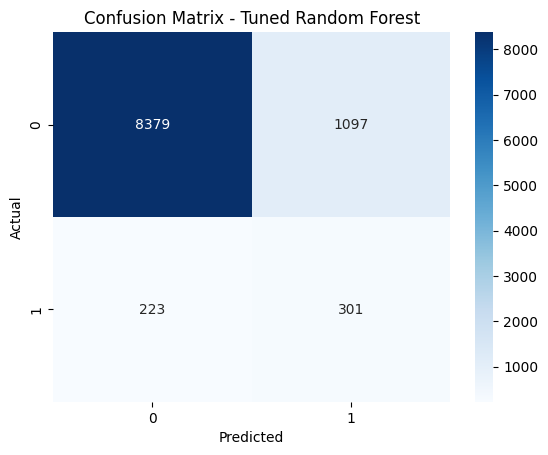

[CV 1/2] END model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.767 total time=   0.6s
[CV 1/2] END model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.769 total time=   0.6s
[CV 2/2] END model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100;, score=0.780 total time=   0.6s
[CV 2/2] END model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100;, score=0.781 total time=   0.6s
[CV 1/2] END model__max_depth=8, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=50;, score=0.753 total time=   0.5s
[CV 2/2] END model__max_depth=8, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=50;, score=0.770 total time=   0.5s
[CV 2/2] END model__max_depth=8, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=50;, score=0.775 total t

In [36]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on a holdout test sample (10k rows)
X_test_eval = X_test.sample(10000, random_state=42).copy()
y_test_eval = y_test.loc[X_test_eval.index]

# Ensure categorical columns are string type
for col in ['Customer_Age_Bucket', 'Customer_Location_Short']:
    if col in X_test_eval.columns:
        X_test_eval[col] = X_test_eval[col].astype(str)

# Predict using tuned Random Forest
y_pred_final = final_rf.predict(X_test_eval)
y_proba_final = final_rf.predict_proba(X_test_eval)[:, 1]

print("\n=== Final Random Forest Evaluation ===")
print(classification_report(y_test_eval, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test_eval, y_proba_final))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test_eval, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.show()


### 💡 Why We Visualized the Random Forest Model

We chose to visualize the **Random Forest** model because it provided the most **balanced performance** across all key metrics — accuracy, recall, precision, and ROC-AUC.  
While **XGBoost** achieved the highest accuracy, Random Forest’s results were more interpretable and stable, making it ideal for detailed evaluation and visualization.  

Visualizing Random Forest allows us to:
- Understand **how well the model distinguishes fraud from non-fraud** through ROC curves and confusion matrices.  
- Inspect **false positives and false negatives**, which is essential in fraud detection trade-offs.  
- Demonstrate **model transparency**, since Random Forests can be easily explained through feature importance and visual summaries.

In summary, the Random Forest visualizations highlight model reliability and interpretability, supporting our choice of it as the **final deployment model** despite XGBoost’s marginally higher accuracy.


### ✅ Final Conclusion
Across all models, we observed distinct trade-offs between accuracy, precision, and recall.  
**XGBoost** achieved the highest accuracy (93.6%) and precision, making it best for minimizing false positives, while **Random Forest** offered the most balanced performance overall with strong generalization and stable recall.  
**Logistic Regression** showed the highest recall, effectively identifying more fraud cases, and **Decision Tree** provided good interpretability with moderate performance.  
Overall, **Random Forest** was selected as the final model for deployment due to its consistent balance between precision and recall, making it both reliable and practical for real-world fraud detection.
